# Gaussian Processes

In this exercise, you will implement Gaussian process regression and apply it to a toy and a real dataset. We use the notation used in the paper "Rasmussen (2005). Gaussian Processes in Machine Learning" linked on ISIS.

Let us first draw a training set $X = (x_1,\dots,x_n)$ and a test set $X_\star = (x^\star_1,\dots,x^\star_m)$ from a $d$-dimensional input distribution. The Gaussian Process is a model under which the real-valued outputs $\mathbf{f} = (f_1,\dots,f_n)$ and $\mathbf{f}_\star = (f^\star_1,\dots,f^\star_m)$ associated to $X$ and $X_\star$ follow the Gaussian distribution:

\begin{equation*}
\left[
\begin{array}{c}\mathbf{f}\\
\mathbf{f}_\star\end{array}
\right]
\sim
\mathcal{N}
\left(
\left[
\begin{array}{c}
\boldsymbol{0}\\
\boldsymbol{0}
\end{array}
\right]
,
\left[
\begin{array}{cc}
\Sigma & \Sigma_\star\\
\Sigma_\star^\top & \Sigma_{\star\star}
\end{array}
\right]
\right)
\end{equation*}

where

\begin{align*}
\Sigma &= k(X,X)+\sigma^2 I\\
\Sigma_\star &= k(X,X_\star)\\
\Sigma_{\star\star} &= k(X_\star,X_\star)+\sigma^2 I
\end{align*}

and where $k(\cdot,\cdot)$ is the Gaussian kernel function. (The kernel function is implemented in `utils.py`.) Predicting the output for new data points $X_\star$ is achieved by conditioning the joint probability distribution on the training set. Such conditional distribution called posterior distribution can be written as:

\begin{equation}
\mathbf{f}_\star | \mathbf{f} \sim \mathcal{N} (
\underbrace{\Sigma_\star^\top \Sigma^{-1} \mathbf{f}}_{\boldsymbol{\mu}_\star}
~,~
\underbrace{\Sigma_{\star\star} - \Sigma_\star^\top \Sigma^{-1} \Sigma_\star}_{C_\star}
)
\end{equation}

Having inferred the posterior distribution, the log-likelihood of observing for the inputs $X_\star$ the outputs $\mathbf{y}_\star$ is given by evaluating the distribution $\mathbf{f}_\star | \mathbf{f}$ at $\mathbf{y}_\star$:

\begin{equation}
\log p(\mathbf{y}_\star | \mathbf{f}) = -\frac1{2} (\mathbf{y}_\star - \boldsymbol{\mu}_\star)^\top C^{-1}_\star (\mathbf{y}_\star - \boldsymbol{\mu}_\star) - \frac1{2}\log|C_\star| - \frac{m}{2}\log2\pi
\end{equation}

where $|\cdot|$ is the determinant. Note that the likelihood of the data given this posterior distribution can be measured both for the training data and the test data.

## Part 1: Implementing a Gaussian Process (30 P)

**Tasks:**

* **Create a class `GP_Regressor` that implements a Gaussian process regressor and has the following three methods:**

 * **`def __init__(self,Xtrain,Ytrain,width,noise):`** Initialize a Gaussian process with noise parameter $\sigma$ and width parameter $w$. The variable `Xtrain` is a two-dimensional array where each row is one data point from the training set. The Variable `Ytrain` is a vector containing the associated targets. The function must also precompute the matrix $\Sigma^{-1}$ for subsequent use by the method `predict()` and `loglikelihood()`.

 * **`def predict(self,Xtest):`** For the test set $X_\star$ of $m$ points received as parameter, return the mean vector of size $m$ and covariance matrix of size $m \times m$ of the corresponding output, that is, return the parameters $(\boldsymbol{\mu}_\star,C_\star)$ of the Gaussian distribution $\mathbf{f}_\star | \mathbf{f}$.

 * **`def loglikelihood(self,Xtest,Ytest):`** For a data set $X_\star$ of $m$ test points received as first parameter, return the loglikelihood of observing the outputs $\mathbf{y}_\star$ received as second parameter.

In [1]:
# imports

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class GP_Regressor:
    
    def __init__(self, Xtrain, Ytrain, width, noise):
        
        self.width = width
        self.noise = noise
        
        self.Xtrain = Xtrain
        self.Ytrain = Ytrain
        
        self.kXX = utils.gaussianKernel(self.Xtrain, self.Xtrain, self.width) 
        
        self.sXX = self.kXX + self.noise**2 * np.identity(len(self.Xtrain))
        
        self.sXXinv = np.linalg.inv(self.sXX)
        
    def predict(self, Xtest):
        
        kXZ = utils.gaussianKernel(self.Xtrain, Xtest, self.width) 
        kZZ = utils.gaussianKernel(Xtest, Xtest, self.width) 
        
        sXZ = kXZ
        sZX = sXZ.T
        sZZ = kZZ + self.noise**2 * np.identity(len(Xtest))
        
        mean = sZX.dot(self.sXXinv).dot(self.Ytrain)
        cov = sZZ - sZX.dot(self.sXXinv).dot(sXZ)
        
        return mean, cov
    
    def loglikelihood(self, Xtest, Ytest):
        
        mean, cov = self.predict(Xtest)
        
        covinv = np.linalg.inv(cov)
        
        Q = -0.5 * covinv.dot(Ytest-mean).dot(Ytest-mean)
        R1 = -0.5 * np.linalg.slogdet(cov)[1]
        R2 = -0.5 * len(Xtest) * np.log(2*np.pi)
        
        return Q + R1 + R2



* **Test your implementation by running the code below (it visualizes the mean and variance of the prediction at every location of the input space) and compares the behavior of the Gaussian process for various noise parameters $\sigma$ and width parameters $w$.**

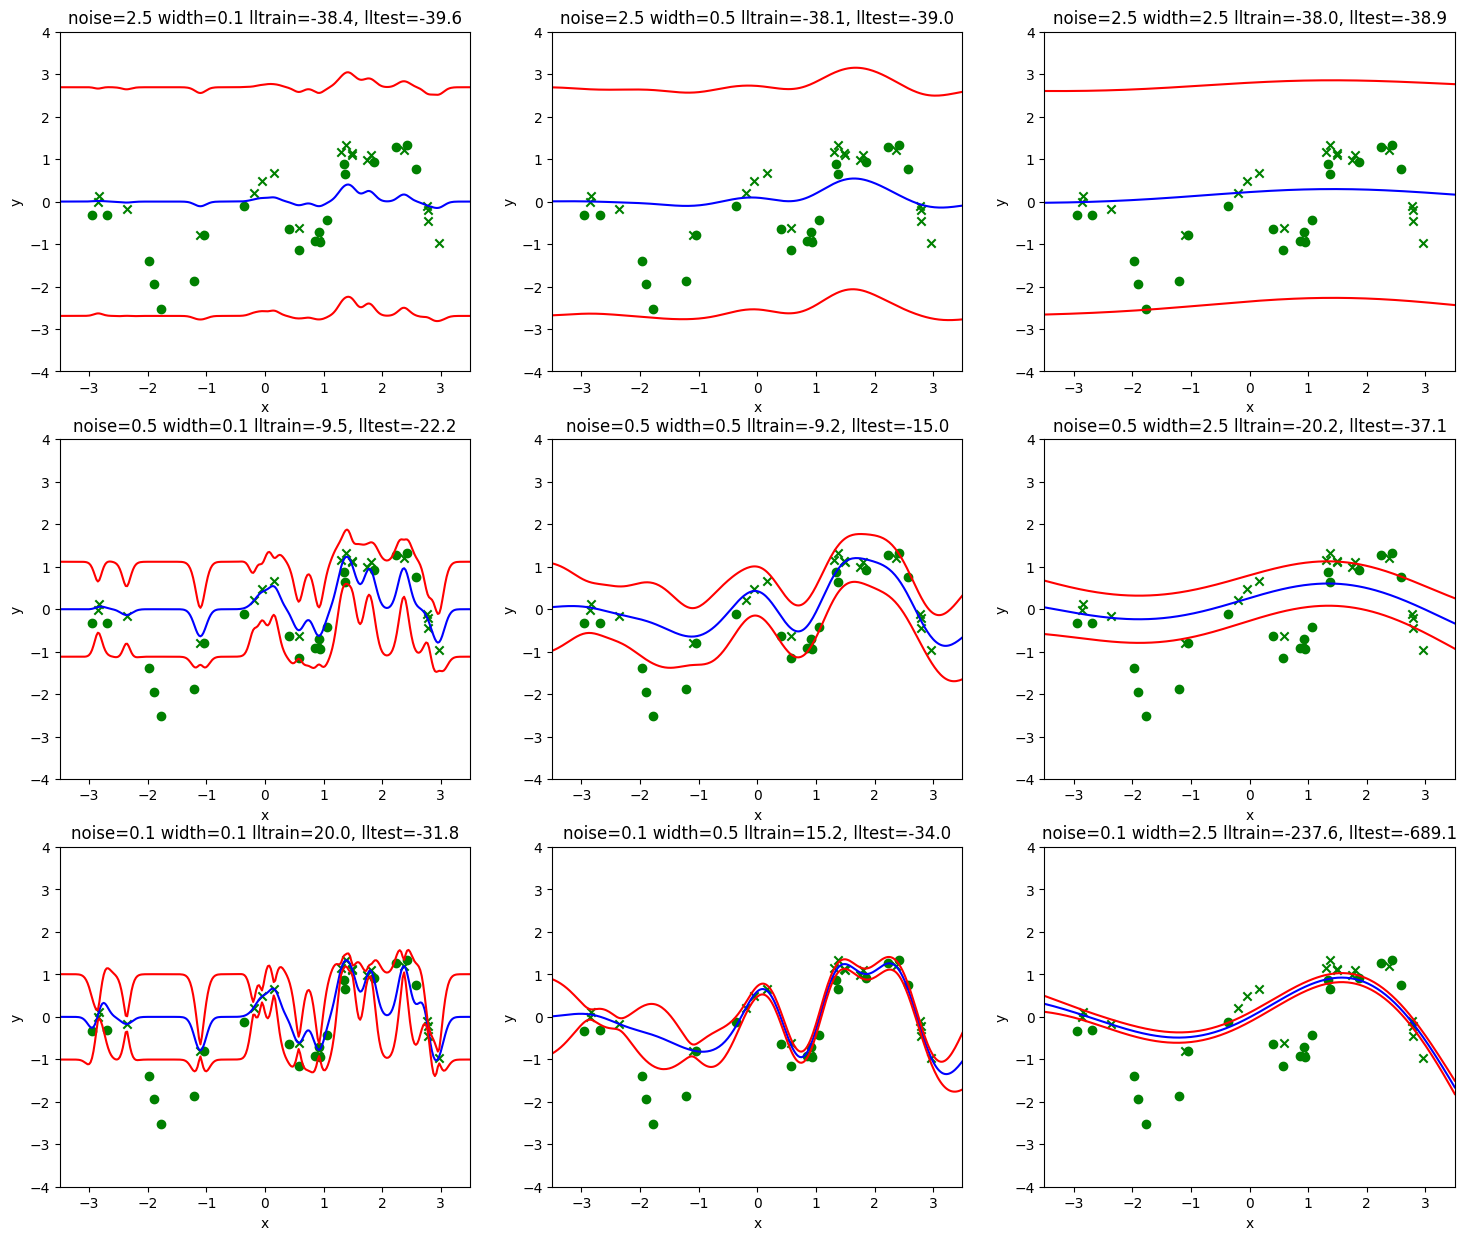

In [5]:
import utils,datasets
import matplotlib.pyplot as plt

# Open the toy data
Xtrain,Ytrain,Xtest,Ytest = utils.split(*datasets.toy())

# Create an analysis distribution
Xrange = np.arange(-3.5,3.51,0.025)[:,np.newaxis]

f = plt.figure(figsize=(18,15))

# Loop over several parameters:
for i,noise in enumerate([2.5,0.5,0.1]):
    for j,width in enumerate([0.1,0.5,2.5]):

        # Create Gaussian process regressor object
        gp = GP_Regressor(Xtrain,Ytrain,width,noise)
        
        # Compute the predicted mean and variance for test data
        mean,cov = gp.predict(Xrange)
        var = cov.diagonal()
        
        # Compute the log-likelihood of training and test data
        lltrain = gp.loglikelihood(Xtrain,Ytrain)
        lltest  = gp.loglikelihood(Xtest ,Ytest )
     
        # Plot the data
        p = f.add_subplot(3,3,3*i+j+1)
        p.set_title('noise=%.1f width=%.1f lltrain=%.1f, lltest=%.1f'%(noise,width,lltrain,lltest))
        p.set_xlabel('x')
        p.set_ylabel('y')
        p.scatter(Xtrain,Ytrain,color='green',marker='x') # training data
        p.scatter(Xtest,Ytest,color='green',marker='o')   # test data
        p.plot(Xrange,mean,color='blue')                  # GP mean
        p.plot(Xrange,mean+var**.5,color='red')           # GP mean + std
        p.plot(Xrange,mean-var**.5,color='red')           # GP mean - std
        p.set_xlim(-3.5,3.5)
        p.set_ylim(-4,4)

## Part 2: Application to the Yacht Hydrodynamics Data Set (20 P)

In the second part, we would like to apply the Gaussian process regressor that you have implemented to a real dataset: the Yacht Hydrodynamics Data Set available on the UCI repository at the webpage http://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics. As stated on the web page, the input variables for this regression problem are:

1. Longitudinal position of the center of buoyancy
2. Prismatic coefficient
3. Length-displacement ratio
4. Beam-draught ratio
5. Length-beam ratio
6. Froude number

and we would like to predict from these variables the residuary resistance per unit weight of displacement (last column in the file `yacht_hydrodynamics.data`).

**Tasks:**

* **Load the data using `datasets.yacht()` and partition the data between training and test set using the function `utils.split()`. Standardize the data (center and rescale) so that each dimension of the training data and the labels have mean 0 and standard deviation 1 over the training set.**


* **Train several Gaussian processes on the regression task using various combinations of width and noise parameters.**


* **Draw two contour plots where the training and test log-likelihood are plotted as a function of the noise and width parameters. Choose suitable ranges of parameters so that the best parameter combination for the test set is in the plot. Use the same ranges and contour levels for the training and test plots. The contour levels can be chosen linearly spaced between e.g. 50 and the maximum log-likelihood value**

5.35 62.42
2.485426487718119 3.6224111460523787


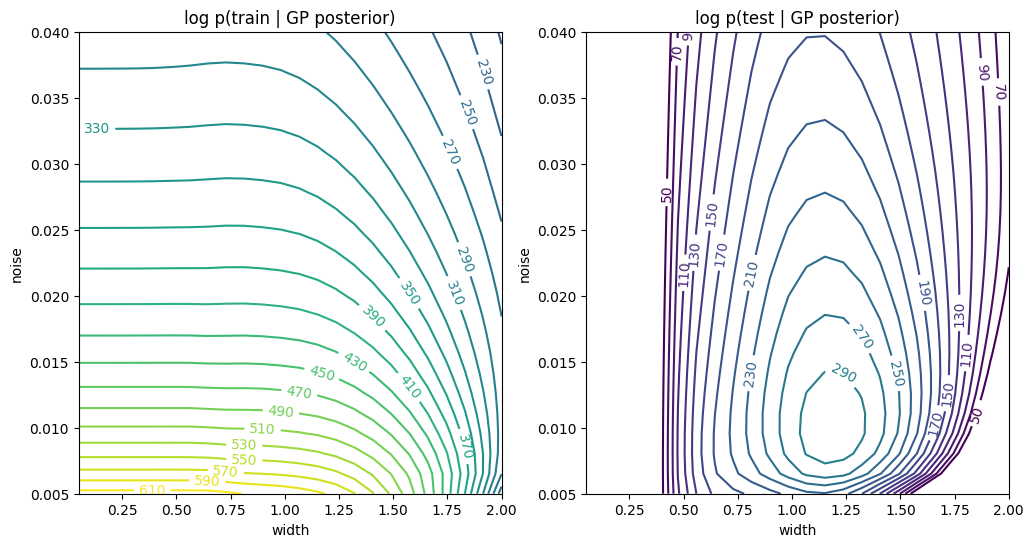

In [6]:
Xtrain, Ytrain, Xtest, Ytest = utils.split(*datasets.yacht())

print(Xtest.max(), Ytest.max())

Xmean, Xstd = Xtrain.mean(axis=0), Xtrain.std(axis=0)
Ymean, Ystd = Ytrain.mean(), Ytrain.std()

Xtrain = (Xtrain - Xmean)/Xstd
Xtest = (Xtest - Xmean)/Xstd

Ytrain = (Ytrain - Ymean)/Ystd
Ytest = (Ytest- Ymean)/Ystd

print(Xtest.max(), Ytest.max())

noises = np.linspace(0.005, 0.04, num=24)
widths = np.linspace(0.05, 2, num=24)

PX, PY = np.meshgrid(widths, noises)

PZ1 = np.zeros([len(noises), len(widths)])
PZ2 = np.zeros([len(noises), len(widths)])

for i, noise in enumerate(noises):
    for j, width in enumerate(widths):
        gp = GP_Regressor(Xtrain, Ytrain, width, noise)
        
        PZ1[i][j] = gp.loglikelihood(Xtrain, Ytrain)
        PZ2[i][j] = gp.loglikelihood(Xtest, Ytest)
        
f = plt.figure(figsize=(12,6))

m = 50
M = max(PZ1.max(), PZ2.max())

p = f.add_subplot(1,2,1)
p.set_title('log p(train | GP posterior)')
p.set_xlabel('width')
p.set_ylabel('noise')
CS = p.contour(PX,PY,PZ1,levels=np.arange(m,M,20))
p.clabel(CS, inline=1, fontsize=10)

p = f.add_subplot(1,2,2)
p.set_title('log p(test | GP posterior)')
p.set_xlabel('width')
p.set_ylabel('noise')
CS = p.contour(PX,PY,PZ2,levels=np.arange(m,M,20))
p.clabel(CS, inline=1, fontsize=10)

plt.show()

